# Functions in Z plane

For most purposes in our code, we don't need beta, we need the Zs derived from beta.  And, we are hoping to integrate over the Z axis.  Thus it would be useful (and possibly simpler) if our functions could directly work with Z inputs.  Here we debug implementations of that.

In [1]:
import numpy as np
from slab import SlabExact
from fiberamp.fiber.microstruct.bragg import plotlogf, plotlogf_real, plotlogf_imag
from scipy.optimize import newton
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use('dark_background')

In [2]:
A = SlabExact(symmetric=True)

In [35]:
field_type = 'TE'
# mode_type = 'leaky'
mode_type = 'guided'

In [36]:
# Here is the simple composition version, translating to Z to Beta and using original implementation

def detZ(Z, field_type='TE', mode_type='guided', indices=None):
    return A.determinant(A.Beta_from_Z(Z), field_type=field_type, mode_type=mode_type, indices=indices)


### Determinant plot of current implementation

Note: all functions with _Z appended to end will be deprecated.  They were the same functions as those without _Z, but designed to work directly with Z inputs instead of Betas.  Their code can be found in the file deprecated.py if one wished to recreate the images in this notebook.

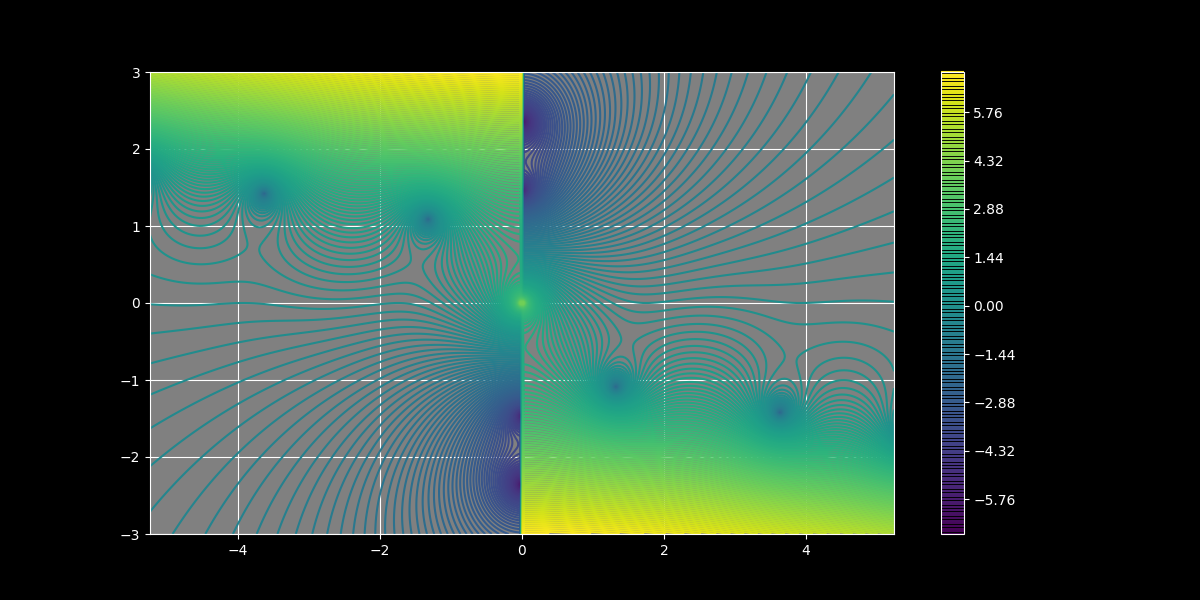

In [114]:
plt.close('all')
plotlogf(A.determinant_Z, -A.K_high, A.K_high, -3, 3, field_type, mode_type, figsize=(12,6),
         iref=300, rref=300,levels=200)

### Determinant plot of simple composition version

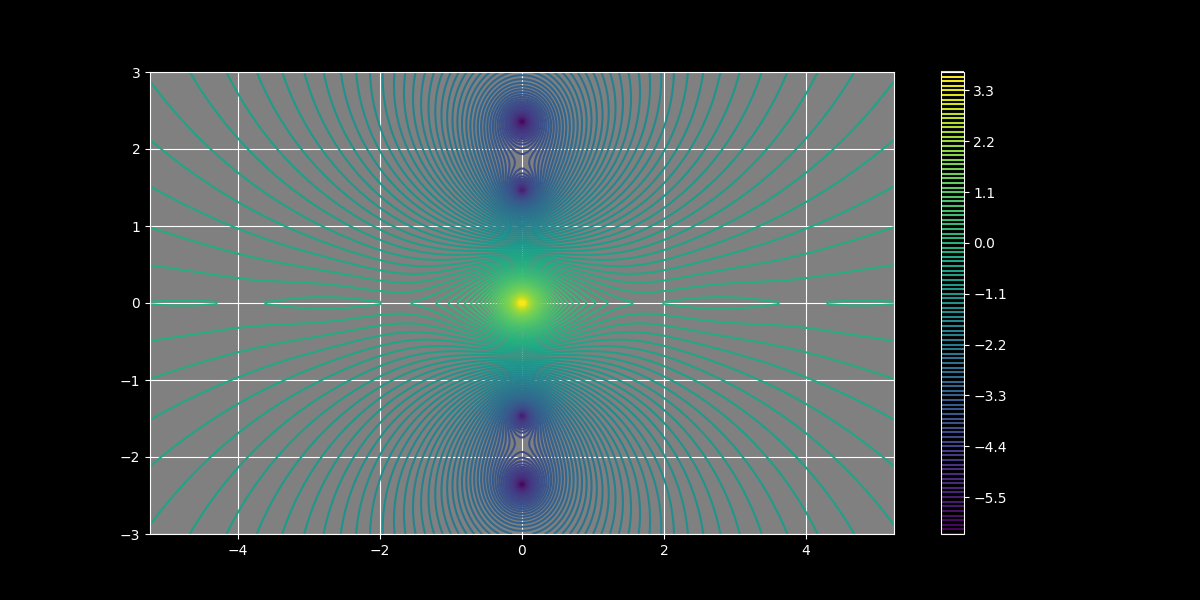

In [113]:
plotlogf(detZ, -A.K_high, A.K_high, -3, 3, field_type, mode_type,figsize=(12,6),
         iref=200, rref=200, levels=110)

### Imaginary axis plots of same

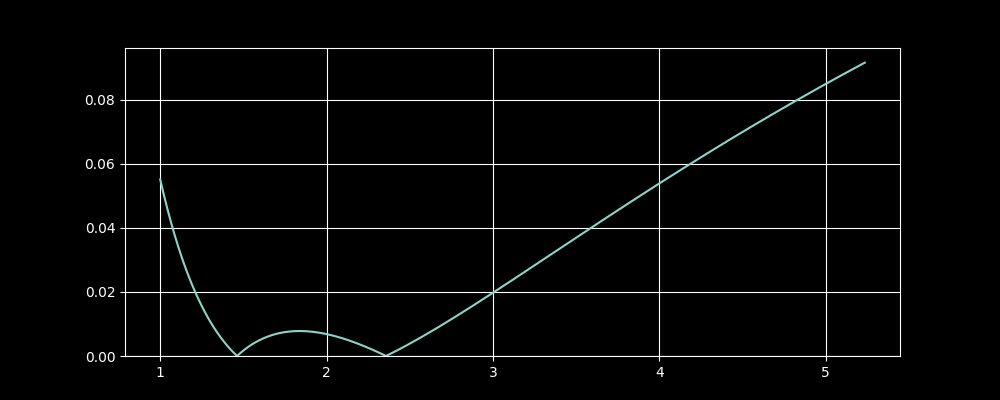

In [80]:
plotlogf_imag(A.determinant_Z, 1, A.K_high, field_type, mode_type, figsize=(10,4), part='real')


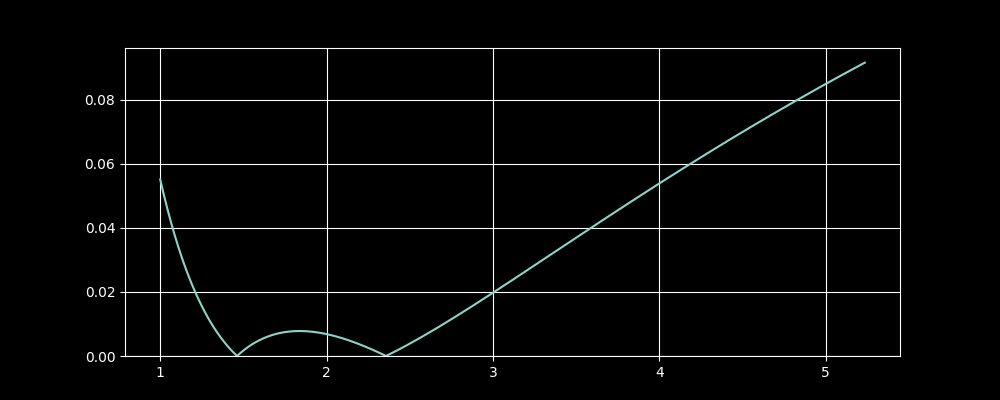

In [112]:
plotlogf_imag(detZ, 1, A.K_high, field_type, mode_type, figsize=(10,4), part='real')


### Root finding using Newton

Current implementation:

In [84]:
Z1 = newton(A.determinant_Z, np.array([1.4j]), args=(field_type, mode_type))
Z1

array([-1.32166237e-16+1.46191937j])

Simple composition:

In [69]:
Z1 = newton(detZ, np.array([1.5j]), args=(field_type, mode_type))
Z1

array([4.07379815e-18+1.46191937j])

### Try using real valued version of our current implemented version

In [87]:
def imag_detZ(im_x, field_type='TE', mode_type='guided'):
    return A.determinant_Z(1j*im_x, field_type=field_type, mode_type=mode_type).real


In [90]:
Z1 = newton(imag_detZ, 1.2, args=(field_type, mode_type))
Z1

1.4619193679047047

### Some conclusions:

The simple composition effectively removes the branch cuts, which helps with root finding when using Newton.  If we use the real valued version of our implementation, that also works, since the branch cuts are gone.  

Not certain which will be the one to choose.  Note though that output from that latter implementation is real, and if the root is in fact pure imaginary you need to account for that.  Overall leaning strongly towards simple composition implemenatation.

### Coefficients

In [96]:
A.coefficients_Z(Z1, mode_type=mode_type, field_type=field_type).T

array([[ 0.00000000e+00+0.j        ,  1.00000000e+00+0.j        ],
       [-6.50315750e-02-0.24740812j,  2.92265172e-02-0.74361366j],
       [-1.11022302e-16-0.22764957j, -1.01382099e+00-0.15489135j]])

Those aren't right.  Should have one of the coefficients in the last region being zero.  Try backwards

In [105]:
Beta = A.Beta_from_Z(Z1*1j)
Beta

(4.767530368632841+0j)

In [100]:
A.coefficients(Beta, mode_type=mode_type, field_type=field_type).T 

array([[ 0.00000000e+00+0.j        ,  1.00000000e+00+0.j        ],
       [ 2.92265172e-02+0.74361366j, -6.50315750e-02+0.24740812j],
       [ 5.55111512e-17+0.22764957j, -1.01382099e+00+0.15489135j]])

Still not right.  Raises question if the betas we get back are correct.  We can check this using the original determinant function:

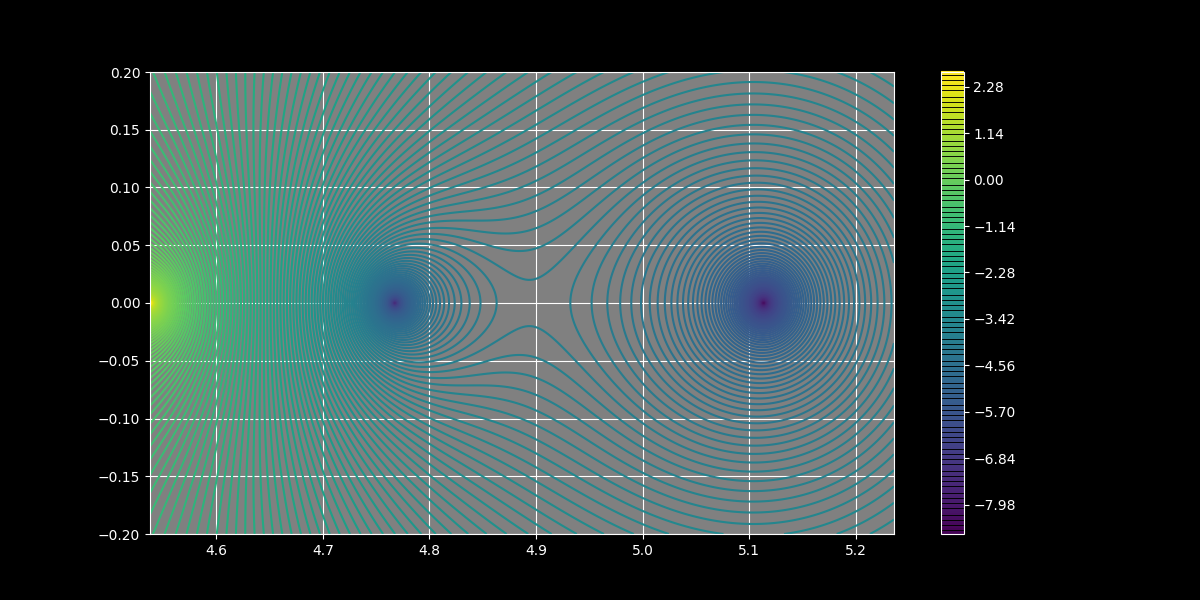

In [104]:
plt.close('all')
plotlogf(A.determinant, A.K_low, A.K_high, -.2, .2, field_type, mode_type, figsize=(12,6),
         iref=300, rref=300,levels=200)

I can already see they aren't right.  And the issue was that the last Z1 I computed was using the real version of the outputs.  Let's get it back correct:

In [106]:
Z1 = newton(detZ, np.array([1.5j]), args=(field_type, mode_type))
Z1

array([4.07379815e-18+1.46191937j])

In [108]:
Beta = A.Beta_from_Z(Z1)
Beta

array([4.76753037-1.24919276e-18j])

That looks better.  Let's see about the coefficients now:

In [109]:
A.coefficients_Z(Z1, mode_type=mode_type, field_type=field_type).T

array([[ 0.00000000e+00+0.j        ,  1.00000000e+00+0.j        ],
       [ 2.69429212e-16+0.13984806j,  2.69073756e-16-0.13984806j],
       [-1.00000000e+00+0.j        , -2.01788703e-16+0.j        ]])

Okay there we go. Let's look at the fields

## Fields

In [110]:
F = A.fields_Z(Z1, field_type=field_type, mode_type=mode_type)

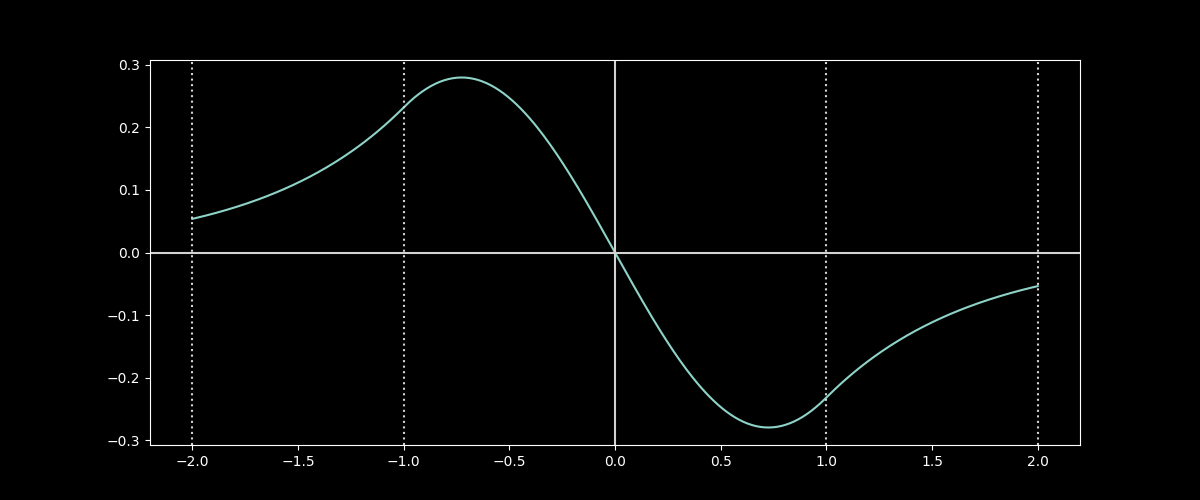

In [111]:
A.plot_field_1d(F)

## Repeat for other guided mode

In [118]:
Z2 = newton(detZ, np.array([2.5j]), args=(field_type, mode_type))
Beta2 = A.Beta_from_Z(Z2)
Z2, Beta2


(array([8.02409001e-17+2.35731407j]), array([5.11361586-3.69900688e-17j]))

In [120]:
F2 = A.fields_Z(Z2, field_type=field_type, mode_type=mode_type)
F2B = A.fields(Beta2, field_type=field_type, mode_type=mode_type)

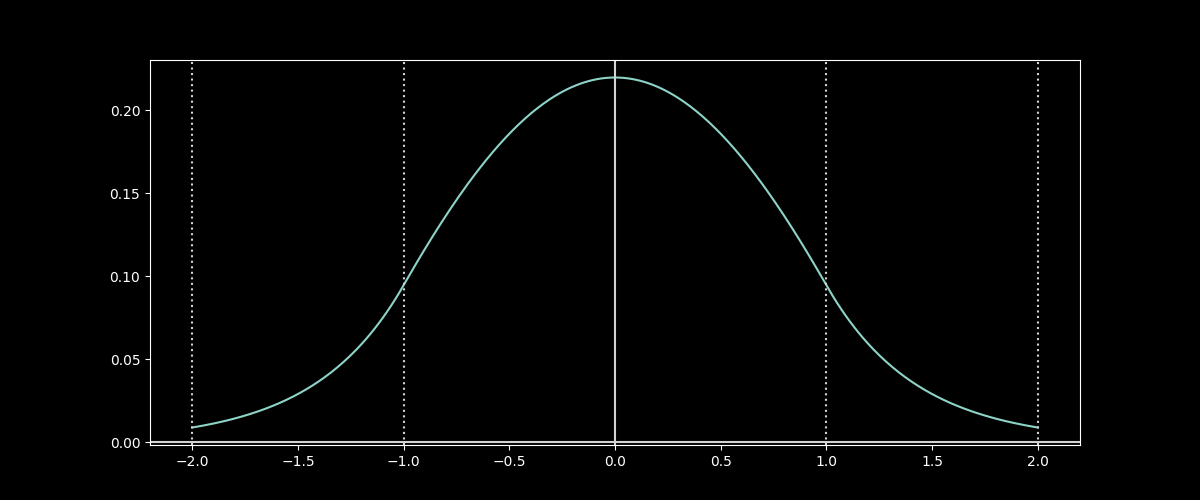

In [121]:
A.plot_field_1d(F2B)

## Deciding on implementation

It would be nice to have one implemenation that could do either the Z or Beta plane.  That works well with the simple composition method, as we can decide at the start with a keyword what plane we are in, and if it's Z we just translate back to Beta and use previous work.  Last question to check is if the simple composition version works for field function (we have already seen it will work for coeffieints).  Above I added some stuff to check that


# Conclusion:

Simple composition version works best; will add keyword at beginning of necessary functions to differentiate between working with Z plane and with Beta plane, allowing old implementation to be kept but extending functionality without writing separate functions.

## Quick last thing: Radiation Modes:

In [123]:
Beta = .5*A.K_low
Z = A.Z_from_Beta(Beta)

FradZ = A.fields_Z(Z, field_type=field_type, mode_type='radiation')
FradB = A.fields(Beta, field_type=field_type, mode_type='radiation')

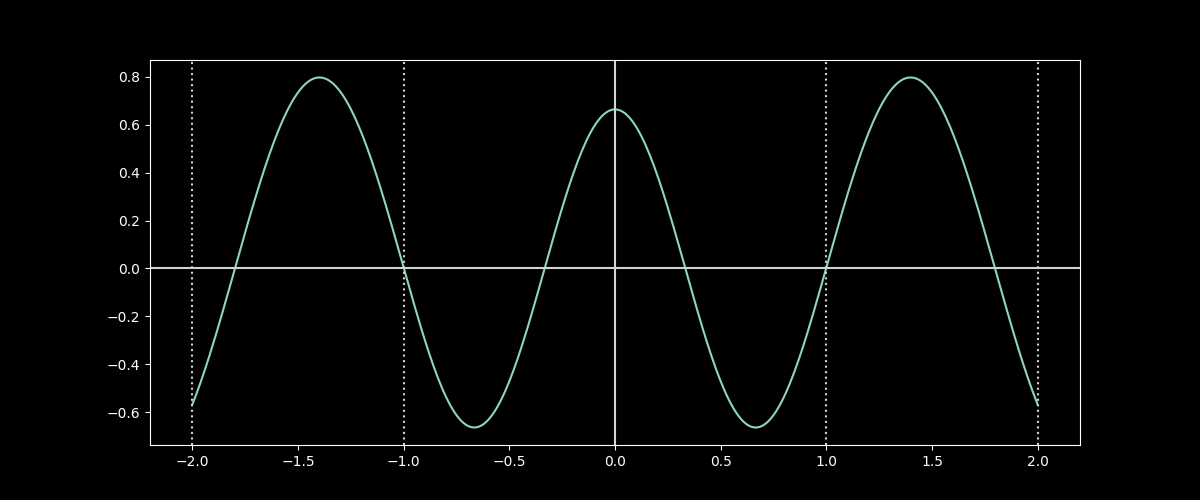

In [124]:
A.plot_field_1d(FradB)

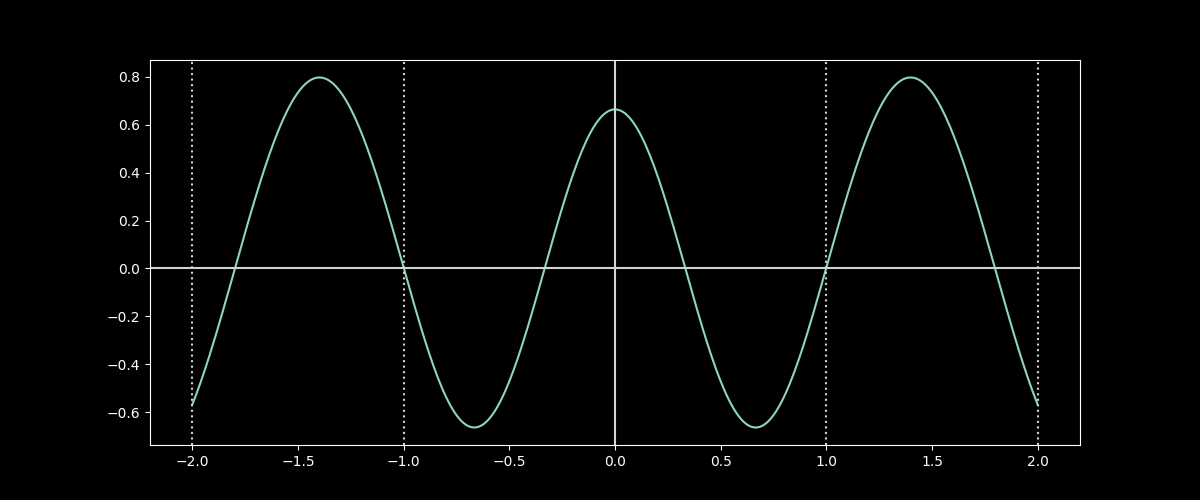

In [125]:
A.plot_field_1d(FradZ)

## Okay, radiation modes will work with that too.